# lets understand the concepts of recommendation system using Movie Lens Small Latest Dataset from kaggle

## 1.1 Importing Libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from tqdm import tqdm
import gensim.downloader as api
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
#!pip install scikit-surprise
from surprise import Reader, Dataset
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score,median_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV as GridSearchCV_SK
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,RobustScaler,PowerTransformer,QuantileTransformer,MinMaxScaler
import xgboost as xgb
from surprise import BaselineOnly,KNNBaseline,SVD,SVDpp
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

     




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Lets pull data from kaggle 

In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset
!unzip movie-lens-small-latest-dataset.zip -d dataset

Saving kaggle.json to kaggle.json
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 58.8MB/s]
Archive:  movie-lens-small-latest-dataset.zip
  inflating: dataset/README.txt      
  inflating: dataset/links.csv       
  inflating: dataset/movies.csv      
  inflating: dataset/ratings.csv     
  inflating: dataset/tags.csv        


## 2.1 lets load the datasets and process files

### 2.1.1 movies.csv

In [2]:
movies_data = pd.read_csv('/content/dataset/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Lets see how content based recommendation works



In [3]:
def year_extractor(title):
  year = re.compile('.*\((\d*)\).*')
  years = year.findall(title)
  if len(years) == 0:
    return title,np.NAN
  else:
    return ' '.join([i.lower() for i in re.split(years[0],title)[0].replace('(','').replace(')','').strip().split()]),years[0]

movies_data['title'],movies_data['year'] = zip(*movies_data['title'].apply(year_extractor))



Dropping non null year records

In [4]:
movies_data=movies_data[~movies_data.year.isna()]

In [5]:
movies_data.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


## extracting title embeddings using word2vec

In [6]:
movies_titles = movies_data.title.values
movies_titles

array(['toy story', 'jumanji', 'grumpier old men', ..., 'flint',
       'bungo stray dogs: dead apple', 'andrew dice clay: dice rules'],
      dtype=object)

In [7]:
Word2Vec = api.load('glove-wiki-gigaword-100')

In [8]:
keys = Word2Vec.wv.vocab.keys()

In [9]:
movies_titles_embeddings = []
for movietitle in tqdm(movies_titles):
  word_tokens = word_tokenize(movietitle)
  sums = np.zeros(100)
  if len(word_tokens) == 0:
    movies_titles_embeddings.append(sums)
  else:
    for word in word_tokens:
      if word in keys:
        sums +=np.array(Word2Vec.wv[word])
      else:
        sums += np.zeros(100)
    movies_titles_embeddings.append(sums)


100%|██████████| 9729/9729 [00:01<00:00, 6588.72it/s]


In [10]:
movies_titles_embeddings = np.array(movies_titles_embeddings)

## extracting genere embeddings using word2vec

In [11]:
movies_genre = movies_data.genres.values
movies_genre

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance', ..., 'Drama',
       'Action|Animation', 'Comedy'], dtype=object)

In [12]:
movies_genre_cleaned = []
for genere in movies_genre:
  genere = ' '.join([i.lower() for i in genere.split('|')])
  movies_genre_cleaned.append(genere)

In [13]:
movies_genre_embeddings = []
for moviegenre in tqdm(movies_genre_cleaned):
  word_tokens = word_tokenize(moviegenre)
  sums = np.zeros(100)
  if len(word_tokens) == 0:
    movies_genre_embeddings.append(sums)
  else:
    for word in word_tokens:
      if word in keys:
        sums +=np.array(Word2Vec.wv[word])
      else:
        sums += np.zeros(100)
    movies_genre_embeddings.append(sums)

100%|██████████| 9729/9729 [00:01<00:00, 7982.69it/s]


In [14]:
movie_year = StandardScaler().fit_transform(movies_data[['year']])

In [15]:
movies_final = pd.DataFrame(np.column_stack((np.array(movies_data[['movieId']]),movies_titles_embeddings,movies_genre_embeddings,movie_year)))
movies_final.head()



,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,1.0,0.169900,1.454370,0.542610,-0.788670,0.222615,0.404000,0.074407,-0.596400,0.755670,...,0.289612,2.270550,-0.535533,0.043597,-1.397068,-1.592415,-1.65463,2.580400,0.220314,0.020846
1,2.0,0.597630,-0.118680,0.526120,0.006265,-0.420860,0.215850,0.917750,0.362880,-0.387450,...,0.692960,2.321750,-0.938290,-0.413660,-0.786298,-1.453310,-0.88313,1.407430,-0.249622,0.020846
2,3.0,2.017530,1.605720,0.558151,-0.769350,-1.958820,2.058460,0.354232,0.734746,-1.019921,...,0.453742,-0.373746,0.650690,0.015102,0.251865,-0.708335,-0.51281,0.139650,0.729560,0.020846
3,4.0,-0.013559,0.637654,1.066180,-0.133284,-0.802887,1.041960,-1.027020,1.295547,0.180740,...,0.191212,-0.652436,1.230290,0.227152,0.596075,-0.158875,-0.88640,0.131153,1.236070,0.020846
4,5.0,0.114315,0.249460,1.994760,0.389760,0.110363,2.056761,-1.454590,-0.069090,-2.337750,...,-0.069618,-0.296330,0.446620,-0.042763,0.160620,0.091555,-0.27336,0.409660,0.439230,0.020846


In [16]:
movies_final[0] = movies_final[0].apply(int)
movies_final.set_index(0,inplace=True)

In [17]:
movie_connection_df = pd.DataFrame(data =list(movies_final.index),columns = ['movieid'])
movie_cosine_similarty = pairwise_distances(movies_final,metric='cosine')

In [18]:
movies_data.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


In [19]:
def top_10_movies_like(movie_id = 1):
  print("*"*30)
  print("Top 10 Movies like : movie : " + str(movies_data[movies_data['movieId'] == movie_id][['title','genres']].values[0][0]) + " *** genre : "+ str(movies_data[movies_data['movieId'] == movie_id][['title','genres']].values[0][1]) )
  print("*"*30 + "\n")
  movie_check_id = movie_connection_df[movie_connection_df.movieid == movie_id].index[0]
  top_10 = np.argsort(movie_cosine_similarty[movie_check_id])[:11]
  top_10_movie_ids = movie_connection_df['movieid'][top_10].values
  if movie_id in top_10_movie_ids:
    top_10_movie_ids = list(top_10_movie_ids)
    top_10_movie_ids.remove(movie_id)
  print(movies_data[movies_data['movieId'].isin(top_10_movie_ids)][['title','genres']])    
  return None

top_10_movies_like(movie_id = 1)



******************************
Top 10 Movies like : movie : toy story *** genre : Adventure|Animation|Children|Comedy|Fantasy
******************************

                  title                                             genres
559           space jam  Adventure|Animation|Children|Comedy|Fantasy|Sc...
2355        toy story 2        Adventure|Animation|Children|Comedy|Fantasy
3194              shrek  Adventure|Animation|Children|Comedy|Fantasy|Ro...
6486    shrek the third        Adventure|Animation|Children|Comedy|Fantasy
6626          enchanted  Adventure|Animation|Children|Comedy|Fantasy|Mu...
7355        toy story 3   Adventure|Animation|Children|Comedy|Fantasy|IMAX
8357     the lego movie  Action|Adventure|Animation|Children|Comedy|Fan...
8806               home  Adventure|Animation|Children|Comedy|Fantasy|Sc...
8900         inside out  Adventure|Animation|Children|Comedy|Drama|Fantasy
8927  the good dinosaur        Adventure|Animation|Children|Comedy|Fantasy


## Lets see some random movie recommendations

In [20]:
for i in np.random.choice(movie_connection_df.movieid.values,size = 10):
  print("-"*50)
  print()
  top_10_movies_like(movie_id = i)
  print()

--------------------------------------------------

******************************
Top 10 Movies like : movie : logan lucky *** genre : Comedy
******************************

                          title              genres
92                happy gilmore              Comedy
550                       eddie              Comedy
757                   big night        Comedy|Drama
3781                lucky break        Comedy|Crime
5512     eddie murphy delirious  Comedy|Documentary
5563           johnny stecchino              Comedy
6271  adam's apples adams æbler        Comedy|Drama
6471                  lucky you        Comedy|Drama
6998                   big stan              Comedy
9161                   just jim              Comedy

--------------------------------------------------

******************************
Top 10 Movies like : movie : quiet man, the *** genre : Drama|Romance
******************************

                       title                    genres
1636        

## Lets use collaberative filtering for recommendations

In [21]:
ratings_data = pd.read_csv('/content/dataset/ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [22]:
ratings_data = ratings_data.sort_values(by=['timestamp'], ascending=True)
ratings_data.head()

,userId,movieId,rating,timestamp
66719,429,595,5.0,828124615
66716,429,588,5.0,828124615
66717,429,590,5.0,828124615
66718,429,592,5.0,828124615
66712,429,432,3.0,828124615


## Lets do some EDA

In [23]:
ratings_data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


## Lets check for null values

* No null values

In [24]:
ratings_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## Lets check for duplicates and remove them
* No duplicate ratings

In [25]:
dup_bool = ratings_data.duplicated(['userId','movieId','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))
del dup_bool, dups

There are 0 duplicate rating entries in the data..


## Basic Statistics of 'userId','movieId' and 'rating'

In [26]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",ratings_data.shape[0])
print("Total No of Users   :", len(np.unique(ratings_data.userId)))
print("Total No of movies  :", len(np.unique(ratings_data.movieId)))

Total data 
--------------------------------------------------

Total no of ratings : 100836
Total No of Users   : 610
Total No of movies  : 9724


 ## Spliting data into Train and Test(80:20) 

In [27]:
train_df = ratings_data.iloc[:int(ratings_data.shape[0]*0.80)]
test_df = ratings_data.iloc[int(ratings_data.shape[0]*0.80):]

## Basic statistics in train data

In [28]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.userId)))
print("Total No of movies  :", len(np.unique(train_df.movieId)))
     


Training data 
--------------------------------------------------

Total no of ratings : 80668
Total No of Users   : 522
Total No of movies  : 7867


## Basic statistics in test data

In [29]:
print("Testing data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.userId)))
print("Total No of movies  :", len(np.unique(test_df.movieId)))
     


Testing data 
--------------------------------------------------

Total no of ratings : 20168
Total No of Users   : 116
Total No of movies  : 5651


## Distribution of ratings in Train data

In [30]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

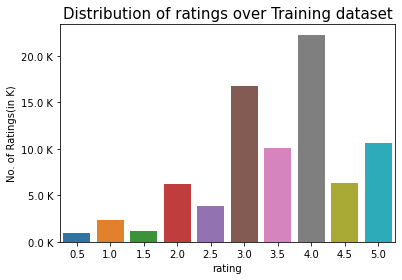

In [31]:
%matplotlib inline
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'K') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(in K)')
plt.show()

## Analysis on the Ratings given by user 

In [32]:
no_of_rated_movies_per_user = train_df.groupby(by='userId')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

userId
414    2516
474    2108
448    1646
274    1346
68     1218
Name: rating, dtype: int64

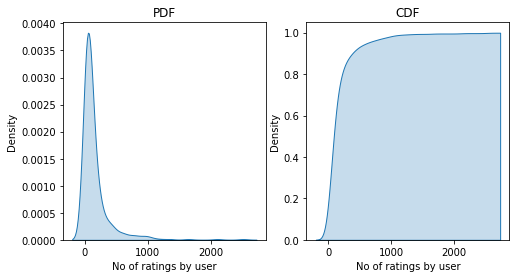

In [33]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()
     


In [34]:
no_of_rated_movies_per_user.describe()

count     522.000000
mean      154.536398
std       247.402723
min        16.000000
25%        35.000000
50%        67.500000
75%       159.750000
max      2516.000000
Name: rating, dtype: float64

## Lets understand the Quantiles for rated movies by user


In [35]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

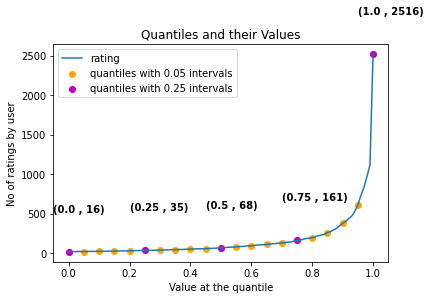

In [36]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')
plt.show()

In [37]:
quantiles[::5]    


0.00      16
0.05      21
0.10      24
0.15      26
0.20      31
0.25      35
0.30      39
0.35      45
0.40      51
0.45      58
0.50      68
0.55      81
0.60      94
0.65     112
0.70     129
0.75     161
0.80     196
0.85     260
0.90     377
0.95     608
1.00    2516
Name: rating, dtype: int64

In [38]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 608)))   


 No of ratings at last 5 percentile : 27



## Analysis of ratings of a movie given by a user 

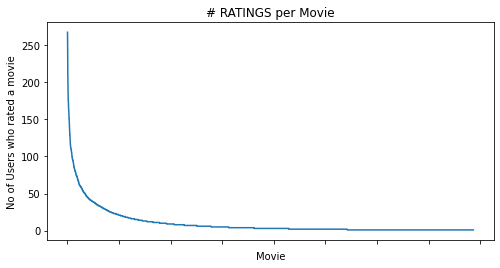

In [39]:
no_of_ratings_per_movie = train_df.groupby(by='movieId')['rating'].count().sort_values(ascending=False)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])
plt.show()    


#### It is very skewed.. just like nunmber of ratings given per user.
* There are some movies (which are very popular) which are rated by huge number of users.
* But most of the movies(like 95%) have ratings less than 50.



## Lets create a sparse datframe from train and test data frame

In [40]:
train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.userId.values,train_df.movieId.values)),)
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )
del us,mv,elem

Sparsity Of Train matrix : 99.91477510137281 % 


In [41]:
test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.userId.values,test_df.movieId.values)),)
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )
del us,mv,elem

Sparsity Of Test matrix : 99.98295119916014 % 


## Finding Global average of all movie ratings, Average rating per user, and  Average rating per movie

In [42]:
def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings
     

### finding global average of all movie ratings

In [43]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5084791986909307}

### finding average rating per user

In [44]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])   


Average rating of user 10 : 3.2785714285714285


### finding average rating per movie

In [45]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])    



 AVerage rating of movie 15 : 3.125


### PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)

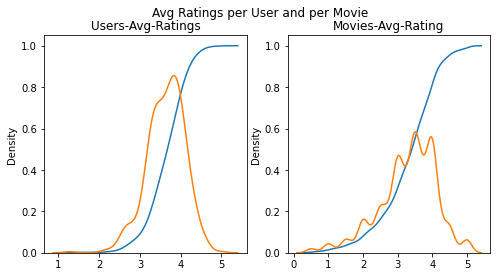

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=12)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()

## Cold Start Problem

### Cold Start problem with Users

In [47]:
total_users = len(np.unique(ratings_data.userId))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,np.round((new_users/total_users)*100, 2)))
     



Total number of Users  : 610

Number of Users in Train data : 522

No of Users that didn't appear in train data: 88(14.43 %) 
 


> We might have to handle new users (88) who didn't appear in train data.

### Cold Start problem with Movies

In [48]:
total_movies = len(np.unique(ratings_data.movieId))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Movies in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,np.round((new_movies/total_movies)*100, 2)))
     



Total number of Movies  : 9724

Number of Movies in Train data : 7867

No of Movies that didn't appear in train data: 1857(19.1 %) 
 


> We might have to handle new users (1857) which didn't appear in train data.

## Computing Similarity matrices

### Computing User-User Similarity matrix 

In [49]:
u_u_sim_sparse = cosine_similarity(X=train_sparse_matrix, dense_output=False)
m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
print("u_u_sim_sparse is a ",u_u_sim_sparse.shape," dimensional matrix")
print("m_m_sim_sparse is a ",m_m_sim_sparse.shape," dimensional matrix")


u_u_sim_sparse is a  (610, 610)  dimensional matrix
m_m_sim_sparse is a  (155169, 155169)  dimensional matrix


In [120]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

## Finding most similar movies using similarity matrix

In [50]:
def top_similar_movies(movieid):
  print("*"*30)
  print("Top 10 Movies like : movie : " + str(movies_data[movies_data['movieId'] == movieid][['title','genres']].values[0][0]) + " *** genre : "+ str(movies_data[movies_data['movieId'] == movieid][['title','genres']].values[0][1]) )
  print("*"*30 + "\n")
  sim_movies = m_m_sim_sparse[movieid].toarray().ravel().argsort()[::-1][1:11]
  print(movies_data[movies_data['movieId'].isin(sim_movies)][['title','genres']])
  return None

top_similar_movies(movieid=1)


******************************
Top 10 Movies like : movie : toy story *** genre : Adventure|Animation|Children|Comedy|Fantasy
******************************

                                           title  \
224           star wars: episode iv - a new hope   
314                                 forrest gump   
418                                jurassic park   
506                                      aladdin   
546                          mission: impossible   
615                  independence day a.k.a. id4   
815          willy wonka & the chocolate factory   
911   star wars: episode vi - return of the jedi   
964                                groundhog day   
2355                                 toy story 2   

                                           genres  
224                       Action|Adventure|Sci-Fi  
314                      Comedy|Drama|Romance|War  
418              Action|Adventure|Sci-Fi|Thriller  
506   Adventure|Animation|Children|Comedy|Musical  
546      

## Lets see some random movie recommendations

In [51]:
for i in np.random.choice(movie_connection_df.movieid.values,size = 10):
  print("-"*50)
  print()
  top_similar_movies(movieid = i)
  print()

--------------------------------------------------

******************************
Top 10 Movies like : movie : drop dead fred *** genre : Comedy|Fantasy
******************************

                                       title  \
373                                cabin boy   
2106  little nemo: adventures in slumberland   
2862                      psycho beach party   
3696                          baby's day out   
4440                               curly sue   
4544                           anything else   
4780                              leprechaun   
5548                                cry-baby   
6353                             harsh times   
6736                         are you scared?   

                                          genres  
373                                       Comedy  
2106  Adventure|Animation|Children|Drama|Fantasy  
2862                      Comedy|Horror|Thriller  
3696                                      Comedy  
4440                          

In [52]:
train_sparse_matrix
test_sparse_matrix


<611x193610 sparse matrix of type '<class 'numpy.float64'>'
	with 20168 stored elements in Compressed Sparse Row format>

## Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from train)

In [53]:
train_averages = dict()

### Finding Global Average of all movie ratings

In [54]:
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = global_average
train_averages

{'global': 3.5084791986909307}

### Finding Average rating per User

In [55]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 20 :',train_averages['user'][20])


Average rating of user 20 : 3.590909090909091


### Finding Average rating per Movie

In [56]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 69 :',train_averages['movie'][69])


 AVerage rating of movie 69 : 3.7777777777777777


### Featurizing data 

In [128]:
print('\n No of ratings in Our train matrix is : {}\n'.format(train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our test  matrix is : {}\n'.format(test_sparse_matrix.count_nonzero()))   



 No of ratings in Our train matrix is : 80668


 No of ratings in Our test  matrix is : 20168



### Featurizing data for regression problem 

#### Featurizing train data 

In [57]:
# get users, movies and ratings from our train sparse matrix
train_users, train_movies, train_ratings = sparse.find(train_sparse_matrix)   


In [ ]:
start = datetime.now()
if os.path.isfile('/content/dataset/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(train_ratings)))
    with open('/content/dataset/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(train_users, train_movies, train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_averages['user'][user])
            # Avg_movie rating
            row.append(train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 80668 tuples for the dataset..

Done for 10000 rows----- 0:02:38.293390
Done for 20000 rows----- 0:05:15.837474
Done for 30000 rows----- 0:07:54.801461
Done for 40000 rows----- 0:10:31.519184
Done for 50000 rows----- 0:13:08.083844
Done for 60000 rows----- 0:15:43.193997
Done for 70000 rows----- 0:18:16.741406
Done for 80000 rows----- 0:20:53.093868
0:21:03.424527


In [58]:
reg_train = pd.read_csv('/content/dataset/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1,1,3.508479,2.0,5.0,4.0,4.0,4.5,3.0,5.0,4.0,3.0,5.0,4.366379,3.923913,4.0
1,5,1,3.508479,4.0,5.0,4.0,4.0,5.0,4.0,3.0,3.0,5.0,3.0,3.636364,3.923913,4.0
2,7,1,3.508479,4.0,4.0,5.0,4.5,4.0,4.5,5.0,5.0,4.0,4.5,3.230263,3.923913,4.5
3,17,1,3.508479,4.0,3.0,4.0,4.0,4.5,4.0,5.0,4.5,5.0,5.0,4.209524,3.923913,4.5
4,18,1,3.508479,5.0,4.0,4.0,5.0,4.0,4.0,4.0,3.5,3.0,4.5,3.696809,3.923913,3.5


#### Featurizing test data 

In [59]:
# get users, movies and ratings from the Test 
test_users, test_movies, test_ratings = sparse.find(test_sparse_matrix) 


In [60]:
train_averages['global']     


3.5084791986909307

In [ ]:
start = datetime.now()

if os.path.isfile('/content/dataset/reg_test.csv'):
  print("It is already created...")
else:
  print('preparing {} tuples for the dataset..\n'.format(len(test_ratings)))
  with open('/content/dataset/reg_test.csv', mode='w') as reg_data_file:
      count = 0 
      for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
          st = datetime.now()

      #--------------------- Ratings of "movie" by similar users of "user" ---------------------
          #print(user, movie)
          try:
              # compute the similar Users of the "user"        
              user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
              top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
              # get the ratings of most similar users for this movie
              top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
              # we will make it's length "5" by adding movie averages to .
              top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
              top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
              # print(top_sim_users_ratings, end="--")

          except (IndexError, KeyError):
              # It is a new User or new Movie or there are no ratings for given user for top similar movies...
              ########## Cold STart Problem ##########
              top_sim_users_ratings.extend([train_averages['global']]*(5 - len(top_sim_users_ratings)))
              #print(top_sim_users_ratings)
          except:
              print(user, movie)
              # we just want KeyErrors to be resolved. Not every Exception...
              raise



          #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
          try:
              # compute the similar movies of the "movie"        
              movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
              top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
              # get the ratings of most similar movie rated by this user..
              top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
              # we will make it's length "5" by adding user averages to.
              top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
              top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
              #print(top_sim_movies_ratings)
          except (IndexError, KeyError):
              #print(top_sim_movies_ratings, end=" : -- ")
              top_sim_movies_ratings.extend([train_averages['global']]*(5-len(top_sim_movies_ratings)))
              #print(top_sim_movies_ratings)
          except :
              raise

          #-----------------prepare the row to be stores in a file-----------------#
          row = list()
          # add usser and movie name first
          row.append(user)
          row.append(movie)
          row.append(train_averages['global']) # first feature
          #print(row)
          # next 5 features are similar_users "movie" ratings
          row.extend(top_sim_users_ratings)
          #print(row)
          # next 5 features are "user" ratings for similar_movies
          row.extend(top_sim_movies_ratings)
          #print(row)
          # Avg_user rating
          try:
              row.append(train_averages['user'][user])
          except KeyError:
              row.append(train_averages['global'])
          except:
              raise
          #print(row)
          # Avg_movie rating
          try:
              row.append(train_averages['movie'][movie])
          except KeyError:
              row.append(train_averages['global'])
          except:
              raise
          #print(row)
          # finalley, The actual Rating of this user-movie pair...
          row.append(rating)
          #print(row)
          count = count + 1

          # add rows to the file opened..
          reg_data_file.write(','.join(map(str, row)))
          #print(','.join(map(str, row)))
          reg_data_file.write('\n')        
          if (count)%5000 == 0:
              #print(','.join(map(str, row)))
              print("Done for {} rows----- {}".format(count, datetime.now() - start))
  print("",datetime.now() - start)  

preparing 20168 tuples for the dataset..

Done for 5000 rows----- 0:01:13.199289
Done for 10000 rows----- 0:02:24.219956
Done for 15000 rows----- 0:03:31.479181
Done for 20000 rows----- 0:04:25.916233
 0:04:26.178025


In [61]:


reg_test_df = pd.read_csv('/content/dataset/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)
     


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,15,1,3.508479,4.5,2.5,2.5,3.0,4.0,1.000000,5.000000,1.000000,2.000000,4.000000,2.843750,3.923913,2.5
1,50,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.923913,3.0
2,73,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.923913,4.5
3,89,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.923913,3.0


### Transforming data for Surprise models

In [62]:
reader = Reader(rating_scale=(0.5,5))

# create the traindata from the dataframe...
surprise_train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
surprise_trainset = surprise_train_data.build_full_trainset() 

#### Transforming test data 

In [63]:
surprise_testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
surprise_testset[:3]
     

[(15, 1, 2.5), (50, 1, 3.0), (73, 1, 4.5)]

# Recommendation using machine learning models

In [75]:
X_train.describe()

,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg
count,1.008700e+04,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000
mean,3.508479e+00,3.518787,3.531972,3.562952,3.544562,3.534698,3.671657,3.695846,3.653068,3.663626,3.677952,3.544942,3.531437
std,8.882224e-16,1.035685,1.014803,1.020482,1.021284,0.999189,0.998041,0.979482,0.977446,0.981874,0.985623,0.404318,0.493388
min,3.508479e+00,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.275000,1.000000
25%,3.508479e+00,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.293103,3.172619
50%,3.508479e+00,3.500000,3.500000,3.666667,3.500000,3.500000,4.000000,4.000000,4.000000,4.000000,4.000000,3.529412,3.530303
75%,3.508479e+00,4.000000,4.000000,4.000000,4.000000,4.000000,4.500000,4.500000,4.000000,4.000000,4.500000,3.809880,3.923913
max,3.508479e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [76]:
X_test.describe()

,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg
count,2.016800e+04,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000
mean,3.508479e+00,3.632555,3.586294,3.543789,3.526848,3.581686,3.531874,3.526990,3.509611,3.526470,3.525552,3.516116,3.554531
std,8.882004e-16,0.900085,0.950830,0.922033,0.893441,0.899308,0.333728,0.329545,0.389320,0.351942,0.319345,0.199439,0.538760
min,3.508479e+00,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,2.458119,0.500000
25%,3.508479e+00,3.000000,3.000000,3.000000,3.000000,3.000000,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.366667
50%,3.508479e+00,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.538462
75%,3.508479e+00,4.000000,4.000000,4.000000,4.000000,4.000000,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.919355
max,3.508479e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.703704,5.000000


In [77]:
y_train.describe()

count    10087.000000
mean         3.531427
std          1.049373
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [64]:
# prepare Train data
X_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
X_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [65]:
result_dataset = pd.DataFrame(data =np.zeros((6,4)) , index = ['r2_score','adjusted_r2_score','median_absolute_error','mean_squared_error','mean_absolute_percentage_error','mean_absolute_error'],columns = ['SVR','DT','RF','GBDT',])
result_dataset

,SVR,DT,RF,GBDT
r2_score,0.0,0.0,0.0,0.0
adjusted_r2_score,0.0,0.0,0.0,0.0
median_absolute_error,0.0,0.0,0.0,0.0
mean_squared_error,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.0,0.0,0.0,0.0
mean_absolute_error,0.0,0.0,0.0,0.0


In [66]:
print(X_train.shape)
print(y_train.shape)
X_train = X_train.dropna()
y_train = y_train.dropna()
print(X_train.shape)
print(y_train.shape)

(10088, 13)
(10088,)
(10087, 13)
(10087,)


In [69]:
def metrics(y_true,y_pred,model = 'SVR'):
  r2_scores = r2_score(y_true,y_pred)
  p = 13 # number of features in the test dataset
  adjusted_r2_scores = 1- (1- r2_score(y_true,y_pred))*(len(y_true)-1)/(len(y_true)-p-1)
  median_absolute_errors = median_absolute_error(y_true,y_pred)
  mean_squared_errors = mean_squared_error(y_true,y_pred)
  mean_absolute_percentage_errors = mean_absolute_percentage_error(y_true,y_pred)
  mean_absolute_errors = mean_absolute_error(y_true,y_pred)
  result_dataset[model]['r2_score'] = r2_scores
  result_dataset[model]['adjusted_r2_score'] = adjusted_r2_scores
  result_dataset[model]['median_absolute_error'] = median_absolute_errors
  result_dataset[model]['mean_squared_error'] = mean_squared_errors
  result_dataset[model]['mean_absolute_percentage_error'] = mean_absolute_percentage_errors
  result_dataset[model]['mean_absolute_error'] = mean_absolute_errors
  print('r2_score for '+ model + " :" + str(r2_scores))
  print('adjusted_r2_score for '+ model + " :" + str(adjusted_r2_scores)) # Adj r2 = 1-(1-R2)*(n-1)/(n-p-1) Where n is the sample size and p is the number of independent variables.
  print('median_absolute_error for '+ model + " :" + str(median_absolute_errors))
  print('mean_squared_error for '+ model + " :" + str(mean_squared_errors))
  print('mean_absolute_percentage_error for '+ model + " :" + str(mean_absolute_percentage_errors))
  print('mean_absolute_error for '+ model + " :" + str(mean_absolute_errors))



## Lets apply SVR

In [68]:
svr_params = {'model__C' : [1.0,0.001,0.1,0.01],'model__kernel' : ['linear','rbf']}
svr_pipe = Pipeline([('model', SVR())])
svr_grid = GridSearchCV(estimator=svr_pipe, param_grid=svr_params,cv = 2, scoring = 'r2',verbose = 2)
svr_grid.fit(X_train, y_train)
svr_grid.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .................model__C=1.0, model__kernel=linear; total time=   5.0s
[CV] END .................model__C=1.0, model__kernel=linear; total time=   3.6s
[CV] END ....................model__C=1.0, model__kernel=rbf; total time=   3.4s
[CV] END ....................model__C=1.0, model__kernel=rbf; total time=   3.4s
[CV] END ...............model__C=0.001, model__kernel=linear; total time=   1.5s
[CV] END ...............model__C=0.001, model__kernel=linear; total time=   1.5s
[CV] END ..................model__C=0.001, model__kernel=rbf; total time=   3.3s
[CV] END ..................model__C=0.001, model__kernel=rbf; total time=   3.4s
[CV] END .................model__C=0.1, model__kernel=linear; total time=   1.8s
[CV] END .................model__C=0.1, model__kernel=linear; total time=   1.8s
[CV] END ....................model__C=0.1, model__kernel=rbf; total time=   3.2s
[CV] END ....................model__C=0.1, model_

Pipeline(steps=[('model', SVR(C=0.1, kernel='linear'))])

In [71]:
y_pred = svr_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'SVR')
result_dataset


r2_score for SVR :0.11586750762743214
adjusted_r2_score for SVR :0.11529721277773275
median_absolute_error for SVR :0.6491944133236092
mean_squared_error for SVR :1.0277351621269957
mean_absolute_percentage_error for SVR :0.38331877093760175
mean_absolute_error for SVR :0.7939678602437913


,SVR,DT,RF,GBDT
r2_score,0.115868,0.0,0.0,0.0
adjusted_r2_score,0.115297,0.0,0.0,0.0
median_absolute_error,0.649194,0.0,0.0,0.0
mean_squared_error,1.027735,0.0,0.0,0.0
mean_absolute_percentage_error,0.383319,0.0,0.0,0.0
mean_absolute_error,0.793968,0.0,0.0,0.0


## Lets Apply Decision Trees

In [73]:
dt_params = {'model__max_depth' : [1,2,3,4,5,6,7,8,9,10]}
dt_pipe = Pipeline([('model', DecisionTreeRegressor())])
dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=dt_params,cv = 2, scoring = 'r2',verbose = 2)
dt_grid.fit(X_train, y_train)
dt_grid.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END .................................model__max_depth=1; total time=   0.0s
[CV] END .................................model__max_depth=1; total time=   0.0s
[CV] END .................................model__max_depth=2; total time=   0.0s
[CV] END .................................model__max_depth=2; total time=   0.0s
[CV] END .................................model__max_depth=3; total time=   0.0s
[CV] END .................................model__max_depth=3; total time=   0.0s
[CV] END .................................model__max_depth=4; total time=   0.0s
[CV] END .................................model__max_depth=4; total time=   0.0s
[CV] END .................................model__max_depth=5; total time=   0.0s
[CV] END .................................model__max_depth=5; total time=   0.0s
[CV] END .................................model__max_depth=6; total time=   0.0s
[CV] END .................................model_

Pipeline(steps=[('model', DecisionTreeRegressor(max_depth=5))])

In [74]:
y_pred = dt_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'DT')
result_dataset

r2_score for DT :0.08771094801291413
adjusted_r2_score for DT :0.08712249124622606
median_absolute_error for DT :0.6730769230769229
mean_squared_error for DT :1.060464969718063
mean_absolute_percentage_error for DT :0.391355566499403
mean_absolute_error for DT :0.8126729766611311


,SVR,DT,RF,GBDT
r2_score,0.115868,0.087711,0.0,0.0
adjusted_r2_score,0.115297,0.087122,0.0,0.0
median_absolute_error,0.649194,0.673077,0.0,0.0
mean_squared_error,1.027735,1.060465,0.0,0.0
mean_absolute_percentage_error,0.383319,0.391356,0.0,0.0
mean_absolute_error,0.793968,0.812673,0.0,0.0


## Lets Apply Random Forest Trees

In [84]:
rf_params = {'model__n_estimators' : [230,240,245],'model__criterion' : ['squared_error'],'model__max_depth' : [100,110,120]}
rf_pipe = Pipeline([('model', RandomForestRegressor())])
rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params,cv = 2, scoring = 'r2',verbose = 2)
rf_grid.fit(X_train, y_train)
rf_grid.best_estimator_

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=230; total time=   6.1s
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=230; total time=   4.8s
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=240; total time=   5.0s
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=240; total time=   5.0s
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=245; total time=   5.1s
[CV] END model__criterion=squared_error, model__max_depth=100, model__n_estimators=245; total time=   5.1s
[CV] END model__criterion=squared_error, model__max_depth=110, model__n_estimators=230; total time=   4.8s
[CV] END model__criterion=squared_error, model__max_depth=110, model__n_estimators=230; total time=   4.8s
[CV] END model__criterion=squared_error, model__max_depth=110, model__n_estimators=2

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=100, n_estimators=230))])

In [85]:
y_pred = rf_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'RF')
result_dataset

r2_score for RF :0.10672004270738011
adjusted_r2_score for RF :0.10614384743870864
median_absolute_error for RF :0.6630434782608696
mean_squared_error for RF :1.038368377650421
mean_absolute_percentage_error for RF :0.3818346879141369
mean_absolute_error for RF :0.8083662452787885


,SVR,DT,RF,GBDT
r2_score,0.115868,0.087711,0.106720,0.0
adjusted_r2_score,0.115297,0.087122,0.106144,0.0
median_absolute_error,0.649194,0.673077,0.663043,0.0
mean_squared_error,1.027735,1.060465,1.038368,0.0
mean_absolute_percentage_error,0.383319,0.391356,0.381835,0.0
mean_absolute_error,0.793968,0.812673,0.808366,0.0


## Lets Use GBDT

In [111]:
gbdt_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[80,90,100,110],'model__max_depth': [1,2,3,4,5]}
gbdt_pipe = Pipeline([('model', GradientBoostingRegressor(random_state = 42))])
gbdt_grid = GridSearchCV(estimator=gbdt_pipe, param_grid=gbdt_params,cv = 2, scoring = 'r2',verbose = 2)
gbdt_grid.fit(X_train, y_train)
gbdt_grid.best_estimator_

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=80; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=80; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=90; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=90; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=2, model__n_estimators=80; total time=   0.3s
[CV] END model__learning_rate=0.01, model__

Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=2, n_estimators=110,
                                           random_state=42))])

In [116]:
y_pred = gbdt_grid.best_estimator_.predict(X_test)
metrics(y_test,y_pred,model = 'GBDT')
result_dataset

r2_score for GBDT :0.10846580577601839
adjusted_r2_score for GBDT :0.10789073658256243
median_absolute_error for GBDT :0.6377634129835399
mean_squared_error for GBDT :1.0363390640510894
mean_absolute_percentage_error for GBDT :0.3792311188922016
mean_absolute_error for GBDT :0.8053023419661108


,SVR,DT,RF,GBDT
r2_score,0.115868,0.087711,0.106720,0.108466
adjusted_r2_score,0.115297,0.087122,0.106144,0.107891
median_absolute_error,0.649194,0.673077,0.663043,0.637763
mean_squared_error,1.027735,1.060465,1.038368,1.036339
mean_absolute_percentage_error,0.383319,0.391356,0.381835,0.379231
mean_absolute_error,0.793968,0.812673,0.808366,0.805302


### Lets analyse the data




In [144]:
result_dataset_surprise = pd.DataFrame(data =np.zeros((4,7)) , index = ['median_absolute_error','mean_squared_error','mean_absolute_percentage_error','mean_absolute_error'],columns = ['XGB','SUR_Baseline','XGB+SUR_Baseline','SUR_KNN','XGB+SUR_Baseline+SUR_KNN','SUR_MF','XGB+SUR_Baseline+SUR_KNN+SUR_MF'])
result_dataset_surprise

,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
def surprise_metrics(y_true,y_pred,model = 'XGB'):
  r2_scores = r2_score(y_true,y_pred)
  p = 13 # number of features in the test dataset
  adjusted_r2_scores = 1- (1- r2_score(y_true,y_pred))*(len(y_true)-1)/(len(y_true)-p-1)
  median_absolute_errors = median_absolute_error(y_true,y_pred)
  mean_squared_errors = mean_squared_error(y_true,y_pred)
  mean_absolute_percentage_errors = mean_absolute_percentage_error(y_true,y_pred)
  mean_absolute_errors = mean_absolute_error(y_true,y_pred)
  result_dataset_surprise[model]['median_absolute_error'] = median_absolute_errors
  result_dataset_surprise[model]['mean_squared_error'] = mean_squared_errors
  result_dataset_surprise[model]['mean_absolute_percentage_error'] = mean_absolute_percentage_errors
  result_dataset_surprise[model]['mean_absolute_error'] = mean_absolute_errors
  #print('r2_score for '+ model + " :" + str(r2_scores))
  #print('adjusted_r2_score for '+ model + " :" + str(adjusted_r2_scores)) # Adj r2 = 1-(1-R2)*(n-1)/(n-p-1) Where n is the sample size and p is the number of independent variables.
  print('median_absolute_error for '+ model + " :" + str(median_absolute_errors))
  print('mean_squared_error for '+ model + " :" + str(mean_squared_errors))
  print('mean_absolute_percentage_error for '+ model + " :" + str(mean_absolute_percentage_errors))
  print('mean_absolute_error for '+ model + " :" + str(mean_absolute_errors))



## Lets use XGBoost

In [97]:
xgb_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[110,130,150,170,200],'model__max_depth':[1,2,3,4,5]}
xgb_pipe = Pipeline([('model', xgb.XGBRegressor(random_state = 42,verbosity = 0))])
xgb_grid = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params,cv = 2, scoring = 'r2',verbose = 2)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_estimator_

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=200; total time=   0.3s
[CV] END model__learning_rate=0.01, mo

Pipeline(steps=[('model',
                 XGBRegressor(max_depth=1, n_estimators=200, random_state=42,
                              verbosity=0))])

In [146]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
surprise_metrics(y_test,y_pred,model = 'XGB')
result_dataset_surprise

median_absolute_error for XGB :0.659548282623291
mean_squared_error for XGB :1.0215456180307199
mean_absolute_percentage_error for XGB :0.37789991877956985
mean_absolute_error for XGB :0.7996891901186656


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,1.021546,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.377900,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,0.799689,0.0,0.0,0.0,0.0,0.0,0.0


### Suprise BaselineModel 


In [151]:
bsl_options = {"method": "sgd","learning_rate": 0.0001,"n_epochs": 10, "reg_u": 5, "reg_i": 5}
bsl_algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(bsl_algo, surprise_train_data, verbose=True,cv = 6)
train_preds = bsl_algo.test(surprise_trainset.build_testset())
train_actual = np.array([pred.r_ui for pred in train_preds])
train_pred = np.array([pred.est for pred in train_preds])
test_preds = bsl_algo.test(surprise_testset)
test_actual = np.array([pred.r_ui for pred in test_preds])
test_pred = np.array([pred.est for pred in test_preds])



Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    1.7880  1.8245  1.7963  1.8091  1.8155  nan     nan     nan     
MAE (testset)     1.4432  1.4875  1.4477  1.4857  1.4795  nan     nan     nan     
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    


In [152]:
surprise_metrics(test_actual,test_pred,model = 'SUR_Baseline')
result_dataset_surprise

median_absolute_error for SUR_Baseline :0.5312834542643037
mean_squared_error for SUR_Baseline :1.1624301266941133
mean_absolute_percentage_error for SUR_Baseline :0.4209369365723356
mean_absolute_error for SUR_Baseline :0.8543639068107941


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.0,0.0,0.0,0.0,0.0
mean_squared_error,1.021546,1.162430,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.377900,0.420937,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,0.799689,0.854364,0.0,0.0,0.0,0.0,0.0


## XGBoost with initial 13 features + Surprise Baseline predictor 

In [156]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = train_pred
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1,1,3.508479,2.0,5.0,4.0,4.0,4.5,3.0,5.0,4.0,3.0,5.0,4.366379,3.923913,4.0,3.609364
1,5,1,3.508479,4.0,5.0,4.0,4.0,5.0,4.0,3.0,3.0,5.0,3.0,3.636364,3.923913,4.0,3.537694


In [163]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = test_pred

reg_test_df.head(2)
     


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,15,1,3.508479,4.5,2.5,2.5,3.0,4.0,1.000000,5.000000,1.000000,2.000000,4.000000,2.843750,3.923913,2.5,3.584418
1,50,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.923913,3.0,3.592455


In [164]:
# prepare Train data
X_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
X_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [165]:
print(X_train.shape)
print(y_train.shape)
X_train = X_train.dropna()
y_train = y_train.dropna()
print(X_train.shape)
print(y_train.shape)

(10088, 14)
(10088,)
(10087, 14)
(10087,)


In [170]:
xgb_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[110,130,150,170,200],'model__max_depth':[1,2,3,4,5]}
xgb_pipe = Pipeline([('model', xgb.XGBRegressor(random_state = 42,verbosity = 0))])
xgb_grid = GridSearchCV_SK(estimator=xgb_pipe, param_grid=xgb_params,cv = 2, scoring = 'neg_root_mean_squared_error',verbose = 2)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_estimator_

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=200; total time=   0.3s
[CV] END model__learning_rate=0.01, mo

Pipeline(steps=[('model',
                 XGBRegressor(max_depth=1, n_estimators=200, random_state=42,
                              verbosity=0))])

In [171]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
surprise_metrics(y_test,y_pred,model = 'XGB+SUR_Baseline')
result_dataset_surprise


median_absolute_error for XGB+SUR_Baseline :0.6594650745391846
mean_squared_error for XGB+SUR_Baseline :1.0210628209301211
mean_absolute_percentage_error for XGB+SUR_Baseline :0.3774182341818955
mean_absolute_error for XGB+SUR_Baseline :0.8002388062829633


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,0.0,0.0,0.0,0.0
mean_squared_error,1.021546,1.162430,1.021063,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.0,0.0,0.0,0.0
mean_absolute_error,0.799689,0.854364,0.800239,0.0,0.0,0.0,0.0


####Surprise KNNBaseline predictor 

## User Based

In [ ]:
'''sim_options = {'user_based' : True,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 
bsl_options = {"method": "sgd","learning_rate": 0.0001,"n_epochs": 10, "reg_u": 5, "reg_i": 5}
knn_bsl_u = KNNBaseline(k=50, sim_options = sim_options, bsl_options = bsl_options)
cross_validate(knn_bsl_u, surprise_train_data, verbose=True,cv = 6)
user_train_preds = knn_bsl_u.test(surprise_trainset.build_testset())
user_train_actual = np.array([pred.r_ui for pred in user_train_preds])
user_train_pred = np.array([pred.est for pred in user_train_preds])
user_test_preds = knn_bsl_u.test(surprise_testset)
user_test_actual = np.array([pred.r_ui for pred in user_test_preds])
user_test_pred = np.array([pred.est for pred in user_test_preds])'''


In [214]:
sim_options = {'user_based' : True,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 
knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u.fit(surprise_trainset)
user_train_preds = knn_bsl_u.test(surprise_trainset.build_testset())
user_train_actual = np.array([pred.r_ui for pred in user_train_preds])
user_train_pred = np.array([pred.est for pred in user_train_preds])
user_test_preds = knn_bsl_u.test(surprise_testset)
user_test_actual = np.array([pred.r_ui for pred in user_test_preds])
user_test_pred = np.array([pred.est for pred in user_test_preds])


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [215]:
surprise_metrics(user_test_actual,user_test_pred,model = 'SUR_KNN')
result_dataset_surprise

median_absolute_error for SUR_KNN :1.5
mean_squared_error for SUR_KNN :3.4914964299881
mean_absolute_percentage_error for SUR_KNN :0.7647367273631651
mean_absolute_error for SUR_KNN :1.526130503768346


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,1.500000,0.659465,1.500000,0.659465
mean_squared_error,1.021546,1.162430,1.021063,3.491496,1.021063,3.491496,1.021063
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.764737,0.377418,0.764737,0.377418
mean_absolute_error,0.799689,0.854364,0.800239,1.526131,0.800239,1.526131,0.800239


## Movie Based

In [ ]:
'''sim_options = {'user_based' : False,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 
bsl_options = {"method": "sgd","learning_rate": 0.0001,"n_epochs": 10, "reg_u": 5, "reg_i": 5}
knn_bsl_u = KNNBaseline(k=50, sim_options = sim_options, bsl_options = bsl_options)
cross_validate(knn_bsl_u, surprise_train_data, verbose=True,cv = 6)
movie_train_preds = knn_bsl_u.test(surprise_trainset.build_testset())
movie_train_actual = np.array([pred.r_ui for pred in movie_train_preds])
movie_train_pred = np.array([pred.est for pred in movie_train_preds])
movie_test_preds = knn_bsl_u.test(surprise_testset)
movie_test_actual = np.array([pred.r_ui for pred in movie_test_preds])
movie_test_pred = np.array([pred.est for pred in movie_test_preds])'''


In [219]:
#sim_options = {'user_based' : False,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 
knn_bsl_u = KNNBaseline(k=40, bsl_options = bsl_options)
knn_bsl_u.fit(surprise_trainset)
movie_train_preds = knn_bsl_u.test(surprise_trainset.build_testset())
movie_train_actual = np.array([pred.r_ui for pred in movie_train_preds])
movie_train_pred = np.array([pred.est for pred in movie_train_preds])
movie_test_preds = knn_bsl_u.test(surprise_testset)
movie_test_actual = np.array([pred.r_ui for pred in movie_test_preds])
movie_test_pred = np.array([pred.est for pred in movie_test_preds])

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


## XGBoost with initial 13 features + Surprise Baseline predictor +  KNNBaseline predictor 

In [220]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = user_train_pred
reg_train['knn_bsl_m'] = movie_train_pred
reg_train.head(2)


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1,1,3.508479,2.0,5.0,4.0,4.0,4.5,3.0,5.0,...,3.0,5.0,4.366379,3.923913,4.0,3.609364,5,5,5,5
1,5,1,3.508479,4.0,5.0,4.0,4.0,5.0,4.0,3.0,...,5.0,3.0,3.636364,3.923913,4.0,3.537694,5,5,5,5


In [181]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['knn_bsl_u'] = user_test_pred
reg_test_df['knn_bsl_m'] = movie_test_pred

reg_test_df.head(2)
     

     


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,15,1,3.508479,4.5,2.5,2.5,3.0,4.0,1.000000,5.000000,1.000000,2.000000,4.000000,2.843750,3.923913,2.5,3.584418,5,5
1,50,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,3.508479,3.508479,3.508479,3.508479,3.923913,3.0,3.592455,5,5


In [182]:
# prepare Train data
X_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
X_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [183]:
print(X_train.shape)
print(y_train.shape)
X_train = X_train.dropna()
y_train = y_train.dropna()
print(X_train.shape)
print(y_train.shape)

(10088, 16)
(10088,)
(10087, 16)
(10087,)


In [184]:
xgb_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[110,130,150,170,200],'model__max_depth':[1,2,3,4,5]}
xgb_pipe = Pipeline([('model', xgb.XGBRegressor(random_state = 42,verbosity = 0))])
xgb_grid = GridSearchCV_SK(estimator=xgb_pipe, param_grid=xgb_params,cv = 2, scoring = 'neg_root_mean_squared_error',verbose = 2)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_estimator_

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, mo

Pipeline(steps=[('model',
                 XGBRegressor(max_depth=1, n_estimators=200, random_state=42,
                              verbosity=0))])

In [185]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
surprise_metrics(y_test,y_pred,model = 'XGB+SUR_Baseline+SUR_KNN')
result_dataset_surprise


median_absolute_error for XGB+SUR_Baseline+SUR_KNN :0.6594650745391846
mean_squared_error for XGB+SUR_Baseline+SUR_KNN :1.0210628209301211
mean_absolute_percentage_error for XGB+SUR_Baseline+SUR_KNN :0.3774182341818955
mean_absolute_error for XGB+SUR_Baseline+SUR_KNN :0.8002388062829633


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,1.500000,0.659465,0.0,0.0
mean_squared_error,1.021546,1.162430,1.021063,3.491496,1.021063,0.0,0.0
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.764737,0.377418,0.0,0.0
mean_absolute_error,0.799689,0.854364,0.800239,1.526131,0.800239,0.0,0.0


## Surprise Matrix Factorization Techniques

### SVD

In [196]:
param_grid = {"n_epochs": [1,2,3,4,5,6,7], "lr_all": [0.001,0.01,0.1,1.0], "reg_all": [0.001,0.01,0.1,1.0],"n_factors": [20,40,60,80]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(surprise_train_data)
print(gs.best_params["rmse"])
svd_algo = gs.best_estimator["rmse"]
svd_algo.fit(surprise_trainset)
svd_train_preds = svd_algo.test(surprise_trainset.build_testset())
svd_train_actual = np.array([pred.r_ui for pred in svd_train_preds])
svd_train_pred = np.array([pred.est for pred in svd_train_preds])
svd_test_preds = svd_algo.test(surprise_testset)
svd_test_actual = np.array([pred.r_ui for pred in svd_test_preds])
svd_test_pred = np.array([pred.est for pred in svd_test_preds])

{'n_epochs': 1, 'lr_all': 0.001, 'reg_all': 0.001, 'n_factors': 20}


In [197]:
surprise_metrics(svd_test_actual,svd_test_pred,model = 'SUR_MF')
result_dataset_surprise

median_absolute_error for SUR_MF :1.5
mean_squared_error for SUR_MF :3.4914964299881
mean_absolute_percentage_error for SUR_MF :0.7647367273631651
mean_absolute_error for SUR_MF :1.526130503768346


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,1.500000,0.659465,1.500000,0.0
mean_squared_error,1.021546,1.162430,1.021063,3.491496,1.021063,3.491496,0.0
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.764737,0.377418,0.764737,0.0
mean_absolute_error,0.799689,0.854364,0.800239,1.526131,0.800239,1.526131,0.0


### SVD PP

In [211]:
param_grid = {"n_epochs": [4,5,6], "lr_all": [0.001,0.01], "reg_all": [0.001,0.01],"n_factors": [5,10,20,25]}
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(surprise_train_data)
print(gs.best_params["rmse"])
svdpp_algo = gs.best_estimator["rmse"]
svdpp_algo.fit(surprise_trainset)
svdpp_train_preds = svdpp_algo.test(surprise_trainset.build_testset())
svdpp_train_actual = np.array([pred.r_ui for pred in svdpp_train_preds])
svdpp_train_pred = np.array([pred.est for pred in svdpp_train_preds])
svdpp_test_preds = svdpp_algo.test(surprise_testset)
svdpp_test_actual = np.array([pred.r_ui for pred in svdpp_test_preds])
svdpp_test_pred = np.array([pred.est for pred in svdpp_test_preds])

{'n_epochs': 4, 'lr_all': 0.001, 'reg_all': 0.001, 'n_factors': 5}


In [202]:
surprise_metrics(svdpp_test_actual,svdpp_test_pred,model = 'SUR_MF')
result_dataset_surprise

median_absolute_error for SUR_MF :1.5
mean_squared_error for SUR_MF :3.4914964299881
mean_absolute_percentage_error for SUR_MF :0.7647367273631651
mean_absolute_error for SUR_MF :1.526130503768346


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,1.500000,0.659465,1.500000,0.0
mean_squared_error,1.021546,1.162430,1.021063,3.491496,1.021063,3.491496,0.0
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.764737,0.377418,0.764737,0.0
mean_absolute_error,0.799689,0.854364,0.800239,1.526131,0.800239,1.526131,0.0


## XGBoost with initial 13 features + Surprise Baseline predictor +  KNNBaseline predictor  + MF techniques

In [203]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = svd_train_pred
reg_train['svdpp'] = svdpp_train_pred
reg_train.head(2)


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1,1,3.508479,2.0,5.0,4.0,4.0,4.5,3.0,5.0,...,3.0,5.0,4.366379,3.923913,4.0,3.609364,5,5,5,5
1,5,1,3.508479,4.0,5.0,4.0,4.0,5.0,4.0,3.0,...,5.0,3.0,3.636364,3.923913,4.0,3.537694,5,5,5,5


In [204]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['svd'] = svd_test_pred
reg_test_df['svdpp'] = svdpp_test_pred

reg_test_df.head(2)
     

     


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,15,1,3.508479,4.5,2.5,2.5,3.0,4.0,1.000000,5.000000,...,2.000000,4.000000,2.843750,3.923913,2.5,3.584418,5,5,5,5
1,50,1,3.508479,3.5,5.0,4.0,5.0,2.0,3.508479,3.508479,...,3.508479,3.508479,3.508479,3.923913,3.0,3.592455,5,5,5,5


In [205]:
# prepare Train data
X_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
X_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [206]:
print(X_train.shape)
print(y_train.shape)
X_train = X_train.dropna()
y_train = y_train.dropna()
print(X_train.shape)
print(y_train.shape)

(10088, 18)
(10088,)
(10087, 18)
(10087,)


In [207]:
xgb_params = {'model__learning_rate' : [0.01,0.1,0.001],'model__n_estimators':[110,130,150,170,200],'model__max_depth':[1,2,3,4,5]}
xgb_pipe = Pipeline([('model', xgb.XGBRegressor(random_state = 42,verbosity = 0))])
xgb_grid = GridSearchCV_SK(estimator=xgb_pipe, param_grid=xgb_params,cv = 2, scoring = 'neg_root_mean_squared_error',verbose = 2)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_estimator_

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=110; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=130; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=150; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=170; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, mo

Pipeline(steps=[('model',
                 XGBRegressor(max_depth=1, n_estimators=200, random_state=42,
                              verbosity=0))])

In [208]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
surprise_metrics(y_test,y_pred,model = 'XGB+SUR_Baseline+SUR_KNN+SUR_MF')
result_dataset_surprise


median_absolute_error for XGB+SUR_Baseline+SUR_KNN+SUR_MF :0.6594650745391846
mean_squared_error for XGB+SUR_Baseline+SUR_KNN+SUR_MF :1.0210628209301211
mean_absolute_percentage_error for XGB+SUR_Baseline+SUR_KNN+SUR_MF :0.3774182341818955
mean_absolute_error for XGB+SUR_Baseline+SUR_KNN+SUR_MF :0.8002388062829633


,XGB,SUR_Baseline,XGB+SUR_Baseline,SUR_KNN,XGB+SUR_Baseline+SUR_KNN,SUR_MF,XGB+SUR_Baseline+SUR_KNN+SUR_MF
median_absolute_error,0.659548,0.531283,0.659465,1.500000,0.659465,1.500000,0.659465
mean_squared_error,1.021546,1.162430,1.021063,3.491496,1.021063,3.491496,1.021063
mean_absolute_percentage_error,0.377900,0.420937,0.377418,0.764737,0.377418,0.764737,0.377418
mean_absolute_error,0.799689,0.854364,0.800239,1.526131,0.800239,1.526131,0.800239
